# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('ucimessages_5_injected_G5.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

62784

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 1082008561, 'u': '1', 'v': '2', 'is_fraud': 0, 'history_type': 'G', 'history_size': 5, 'bip': False, 'cost': 0.0}
{'t': 1082008561, 'u': '1352', 'v': '1685', 'is_fraud': 1, 'history_type': 'G', 'history_size': 5, 'bip': False, 'cost': 0.0}
{'t': 1082123439, 'u': '3', 'v': '4', 'is_fraud': 0, 'history_type': 'G', 'history_size': 5, 'bip': False, 'cost': 0.0, 'number_of_nodes': 2, 'degrees_nb_one': 2, 'degrees_nb_two': 0, 'degrees_min': 1, 'degrees_max': 1, 'degrees_median': 1, 'weighted_degrees_nb_one': 2, 'weighted_degrees_nb_two': 0, 'weighted_degrees_min': 1, 'weighted_degrees_max': 1, 'weighted_degrees_median': 1, 'u_degree': 1, 'v_degree': 1, 'u_same_degree': 2, 'v_same_degree': 2, 'u_greater_degree': 0, 'v_greater_degree': 0, 'u_weighted_degree': 1, 'v_weighted_degree': 1, 'u_same_weighted_degree': 2, 'v_same_weighted_degree': 2, 'u_greater_weighted_degree': 0, 'v_greater_weighted_degree': 0, 'number_of_links': 1, 'total_weight': 1, 'link_weights_nb_one': 1, 'link_weights_nb

# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 1082008561,
 'u': '1',
 'v': '2',
 'is_fraud': 0,
 'history_type': 'G',
 'history_size': 5,
 'bip': False,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1082381991,2,5,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1082407219,6,7,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62780,1098744436,1097,1899,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62781,1098744603,1899,277,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62782,1098744711,1624,1878,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1082381991,2,5,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1082407219,6,7,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62780,1098744436,1097,1899,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62781,1098744603,1899,277,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62782,1098744711,1624,1878,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278400e+04,62784.000000,62784.0,6.278400e+04,62782.000000,62782.000000,62782.000000,62782.0,62782.000000,62782.0,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000
mean,1.086024e+09,0.047608,5.0,9.954766e-07,2.410723,2.397136,0.011213,1.0,1.077618,1.0,2.386942,0.019671,1.004157,1.085470,1.004205,1.000032,1.076344,2.397104,2.313641,0.013523,0.001099,1.004699,1.084005,2.388312,2.312526,0.016342,0.001481,1.244226,1.252079,1.237775,0.005384,1.004157,1.006467,1.004157,1.004667,1.236087,0.002628
std,3.186740e+06,0.212936,0.0,1.247140e-04,1.988671,1.950100,0.106203,0.0,1.743535,0.0,1.879584,0.170203,0.081978,1.846576,0.082267,0.005644,1.742613,1.950090,0.867232,0.116188,0.033134,0.085376,1.845668,1.806175,0.866202,0.163741,0.043144,1.819853,1.919804,1.740159,0.092759,0.081978,0.099486,0.081978,0.085191,1.664041,0.089114
min,1.082009e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.085087e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,1.086349e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.098745e+09,1.000000,5.0,1.562500e-02,81.000000,80.000000,2.000000,1.0,78.000000,1.0,75.000000,4.000000,4.000000,84.000000,4.000000,2.000000,78.000000,80.000000,15.000000,2.000000,1.000000,4.000000,84.000000,75.000000,15.000000,6.000000,2.000000,79.000000,85.000000,74.000000,4.000000,4.000000,4.000000,4.000000,4.000000,74.000000,5.000000


# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1082123439,3,4,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1082381991,2,5,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1082407219,6,7,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1082407356,7,8,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
6,1082408003,10,9,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
7,1082408053,11,9,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
8,1082408788,12,13,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
9,1082409354,14,9,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
2,1082123439,3,4,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1082381991,2,5,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1082407219,6,7,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1082407356,7,8,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
6,1082408003,10,9,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,1098744248,1847,1899,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62780,1098744436,1097,1899,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62781,1098744603,1899,277,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62782,1098744711,1624,1878,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1082008561,1,2,0,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1082008561,1352,1685,1,G,5,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,6.278200e+04,62782.000000,62782.0,6.278200e+04,62782.000000,62782.000000,62782.000000,62782.0,62782.000000,62782.0,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000
mean,1.086024e+09,0.047593,5.0,9.955083e-07,2.410723,2.397136,0.011213,1.0,1.077618,1.0,2.386942,0.019671,1.004157,1.085470,1.004205,1.000032,1.076344,2.397104,2.313641,0.013523,0.001099,1.004699,1.084005,2.388312,2.312526,0.016342,0.001481,1.244226,1.252079,1.237775,0.005384,1.004157,1.006467,1.004157,1.004667,1.236087,0.002628
std,3.186710e+06,0.212906,0.0,1.247160e-04,1.988671,1.950100,0.106203,0.0,1.743535,0.0,1.879584,0.170203,0.081978,1.846576,0.082267,0.005644,1.742613,1.950090,0.867232,0.116188,0.033134,0.085376,1.845668,1.806175,0.866202,0.163741,0.043144,1.819853,1.919804,1.740159,0.092759,0.081978,0.099486,0.081978,0.085191,1.664041,0.089114
min,1.082123e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.083976e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.085087e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,1.086349e+09,0.000000,5.0,0.000000e+00,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.098745e+09,1.000000,5.0,1.562500e-02,81.000000,80.000000,2.000000,1.0,78.000000,1.0,75.000000,4.000000,4.000000,84.000000,4.000000,2.000000,78.000000,80.000000,15.000000,2.000000,1.000000,4.000000,84.000000,75.000000,15.000000,6.000000,2.000000,79.000000,85.000000,74.000000,4.000000,4.000000,4.000000,4.000000,4.000000,74.000000,5.000000


In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
2,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62780,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62781,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62782,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [18]:
df_features.describe()

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,62782.000000,62782.000000,62782.000000,62782.000000,62782.0,62782.000000,62782.0,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000,62782.000000
mean,0.047593,2.410723,2.397136,0.011213,1.0,1.077618,1.0,2.386942,0.019671,1.004157,1.085470,1.004205,1.000032,1.076344,2.397104,2.313641,0.013523,0.001099,1.004699,1.084005,2.388312,2.312526,0.016342,0.001481,1.244226,1.252079,1.237775,0.005384,1.004157,1.006467,1.004157,1.004667,1.236087,0.002628
std,0.212906,1.988671,1.950100,0.106203,0.0,1.743535,0.0,1.879584,0.170203,0.081978,1.846576,0.082267,0.005644,1.742613,1.950090,0.867232,0.116188,0.033134,0.085376,1.845668,1.806175,0.866202,0.163741,0.043144,1.819853,1.919804,1.740159,0.092759,0.081978,0.099486,0.081978,0.085191,1.664041,0.089114
min,0.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,0.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,0.000000,2.000000,2.000000,0.000000,1.0,1.000000,1.0,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,81.000000,80.000000,2.000000,1.0,78.000000,1.0,75.000000,4.000000,4.000000,84.000000,4.000000,2.000000,78.000000,80.000000,15.000000,2.000000,1.000000,4.000000,84.000000,75.000000,15.000000,6.000000,2.000000,79.000000,85.000000,74.000000,4.000000,4.000000,4.000000,4.000000,4.000000,74.000000,5.000000


In [19]:
df_target = df["is_fraud"]
df_target

2        0
3        0
4        0
5        0
6        0
        ..
62779    0
62780    0
62781    0
62782    0
62783    0
Name: is_fraud, Length: 62782, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
2,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43944,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43945,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43946,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43947,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [23]:
test_df

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
43949,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43950,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43951,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43952,1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43953,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62779,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62780,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62781,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62782,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    41844
1     2103
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

41844
2103


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(41844, 34)
(2103, 34)


In [28]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.376924,2.362274,0.014435,1.0,1.014697,1.0,2.355798,0.020457,1.002868,1.018187,1.002939,1.000048,1.013479,2.362226,2.341841,0.014554,0.001219,1.00337,1.016824,2.361008,2.340694,0.014865,0.001506,1.195894,1.199383,1.192620,0.003083,1.002868,1.003489,1.002868,1.003322,1.195249,0.000167
1,3.326201,3.317166,0.009035,1.0,1.009035,1.0,3.314313,0.011888,1.000000,1.010461,1.000000,1.000000,1.001902,3.317166,3.315264,0.009035,0.007133,1.00000,1.001902,3.314313,3.312411,0.011888,0.009986,1.667618,1.669044,1.666191,0.001427,1.000000,1.001427,1.000000,1.000000,1.666191,0.001427


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
4192,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
28542,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5757,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
41355,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
10605,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
43807,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
43830,1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43861,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    2103
1    2103
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.384689,2.366619,0.017594,1.0,1.018545,1.0,2.359962,0.023300,1.003804,1.022349,1.003804,1.0,1.017118,2.366619,2.340942,0.018069,0.001427,1.003804,1.020922,2.366619,2.340942,0.018069,0.001427,1.201617,1.205421,1.198288,0.002853,1.003804,1.003804,1.003804,1.003804,1.201617,0.000000
1,3.326201,3.317166,0.009035,1.0,1.009035,1.0,3.314313,0.011888,1.000000,1.010461,1.000000,1.0,1.001902,3.317166,3.315264,0.009035,0.007133,1.000000,1.001902,3.314313,3.312411,0.011888,0.009986,1.667618,1.669044,1.666191,0.001427,1.000000,1.001427,1.000000,1.000000,1.666191,0.001427


In [34]:
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
4192,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
28542,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5757,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
41355,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
10605,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
43807,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
43830,1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
43861,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
2911,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
26125,0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
33853,1,6.0,6.0,0.0,1.0,1.0,1.0,6.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,6.0,0.0,0.0,1.0,1.0,6.0,6.0,0.0,0.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0
33896,1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
42753,1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27657,1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
11433,0,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
20940,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0
34529,1,4.0,4.0,0.0,1.0,1.0,1.0,4.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,0.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    17950
1      885
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.341950,2.329749,0.004457,1.0,1.235432,1.0,2.309638,0.019554,1.007855,1.254540,1.007855,1.0,1.235376,2.329749,2.085571,0.012201,0.000056,1.008579,1.254373,2.302284,2.084791,0.020891,0.000279,1.288691,1.307799,1.273983,0.011421,1.007855,1.014262,1.007855,1.008579,1.261950,0.008579
1,3.228249,3.225989,0.001130,1.0,1.014689,1.0,3.223729,0.003390,1.000000,1.015819,1.000000,1.0,1.000000,3.225989,3.225989,0.002260,0.002260,1.000000,1.000000,3.223729,3.223729,0.004520,0.004520,1.621469,1.622599,1.620339,0.001130,1.000000,1.001130,1.000000,1.000000,1.620339,0.001130


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    17950
1      885
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.7654


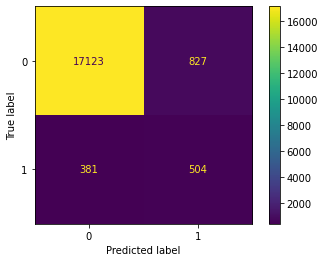

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

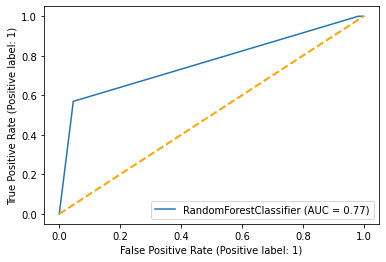

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
2,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62777,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62778,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62779,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62780,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [47]:
y

0        0
1        0
2        0
3        0
4        0
        ..
62777    0
62778    0
62779    0
62780    0
62781    0
Name: is_fraud, Length: 62782, dtype: int64

In [48]:
len(df) / 2

31391.0

In [49]:
8353+8350

16703

In [50]:
len(df)

62782

In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 627 



In [52]:
len(df)

62782

In [53]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 627 

RangeIndex(start=0, stop=31391, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 1198, 1198
Counts of y = 1 and y = 0 in y_test: 323, 5956
0
Iteration difference 31391: ROC-AUC=0.6900
------------------------------------------------------------------------------------------------
RangeIndex(start=627, stop=32018, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 1205, 1205
Counts of y = 1 and y = 0 in y_test: 324, 5955
627
Iteration difference 31391: ROC-AUC=0.6885
------------------------------------------------------------------------------------------------
RangeIndex(start=1254, stop=32645, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 1208, 1208
Counts of y = 1 and y = 0 in y_test: 315, 5964
1254
Iteration difference 31391: ROC-AUC=0.6965
------------------------------------------------------------------------------------------------
RangeIndex(start=1881, stop=33272, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 1216, 1216

16929
Iteration difference 31391: ROC-AUC=0.7333
------------------------------------------------------------------------------------------------
RangeIndex(start=17556, stop=48947, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1216, 1216
Counts of y = 1 and y = 0 in y_test: 305, 5974
17556
Iteration difference 31391: ROC-AUC=0.7353
------------------------------------------------------------------------------------------------
RangeIndex(start=18183, stop=49574, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1220, 1220
Counts of y = 1 and y = 0 in y_test: 301, 5978
18183
Iteration difference 31391: ROC-AUC=0.7419
------------------------------------------------------------------------------------------------
RangeIndex(start=18810, stop=50201, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1223, 1223
Counts of y = 1 and y = 0 in y_test: 304, 5975
18810
Iteration difference 31391: ROC-AUC=0.7418
---------------------------------------------------

In [54]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,number_of_nodes,degrees_nb_one,degrees_nb_two,degrees_min,degrees_max,degrees_median,weighted_degrees_nb_one,weighted_degrees_nb_two,weighted_degrees_min,weighted_degrees_max,weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
62780,1098744711,1624,1878,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
62781,1098744742,1624,1878,0,G,5,False,0.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [55]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("DNCEmails-5Perc-G5-AUCInSlidingWindow.xlsx", index=False)

In [56]:
len(roc_auc_results)

51

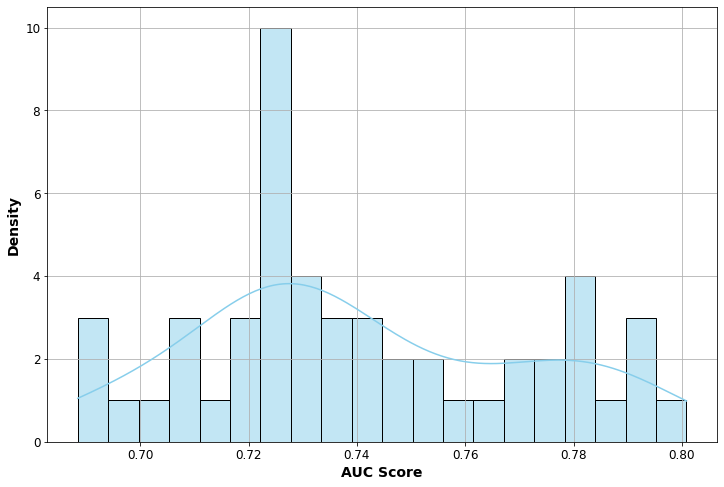

In [57]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()